In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+555.g9b2e71684.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.67 GB available memory.


# 1D

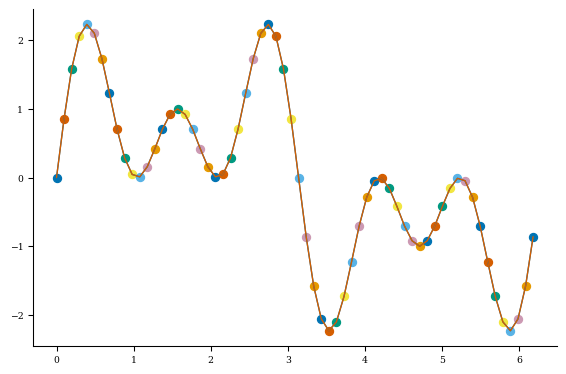

In [6]:
def f(x):
    """1D periodic function."""
    return np.sin(x) + np.sin(3 * x) + np.sin(5 * x)

N = 64
xk = np.linspace(0, 2*np.pi, N, endpoint=False)
yk = f(xk)
xm = np.fft.fft(yk)
x = np.fft.ifft(xm)
plt.plot(xk, yk)
plt.plot(xk, x.real)
k = np.fft.fftfreq(N) * N
for x0 in xk:
    expk = jnp.exp(1j * k * x0)
    f0 = xm @ expk / N
    plt.scatter(x0, f0.real)

# 1D with rfft()

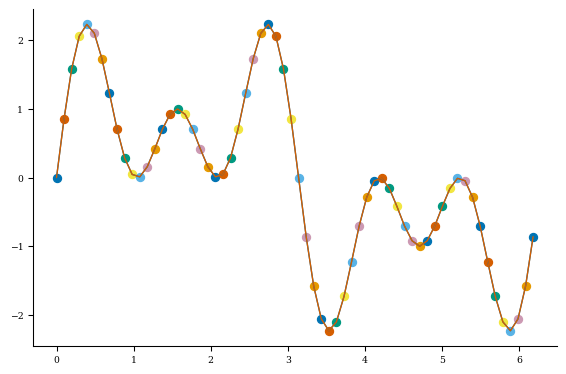

In [7]:
N = 64
xk = np.linspace(0, 2 * np.pi, N, endpoint=False)
yk = f(xk)
xm = np.fft.rfft(yk)
x = np.fft.irfft(xm)
plt.plot(xk, yk)
plt.plot(xk, x.real)
k = np.fft.rfftfreq(N) * N
for x0 in xk:
    expk = jnp.exp(1j * k * x0)
    terms = xm * expk / N
    f0 = jnp.sum(terms[1:-1])
    f0 += jnp.sum(jnp.conjugate(terms[1:-1]))
    f0 += terms[0] + terms[-1]
    plt.scatter(x0, f0.real)

# 2D

In [178]:
def plot_2d_surface(x, y, z):
    """Plot data on a surface using a 3D plot."""
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale="Viridis", opacity=1)])
    fig.update_layout(
        title="Plotly Interactive 3D Surface Plot",
        scene=dict(
            xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode="data"
        ),
        width=800,
        height=800,
    )
    return fig

In [179]:
def f2(x, y):
    """2D periodic function."""
    return 2*np.sin(x*y)

x = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, x)
z = f2(X, Y)
plot_2d_surface(X, Y, z)

In [180]:
N = 64
x = np.linspace(0, 2 * np.pi, N)
X, Y = np.meshgrid(x, x)
zk = f2(X, Y)
# take the FFT of the data
# order doesn't matter
zm = np.fft.fft(zk, axis=1)
zmn = np.fft.fft(zm, axis=0)

# go back to time domain with 2 inverse FFTs
# order doesn't matter
zm = np.fft.ifft(zmn, axis=0)
z = np.fft.ifft(zm, axis=1)
plot_2d_surface(X, Y, z.real)

# Chebyshew Transform

In [4]:
def f_np(x):
    """Non-periodic 1D function."""
    return 4*x**3-3*x

N = 32
lobatto = False
k = np.arange(N)
if lobatto:
    x = jnp.cos(jnp.pi * k / (N - 1))
else:
    x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * N))
x = (x+1)/2
y = f_np(x)

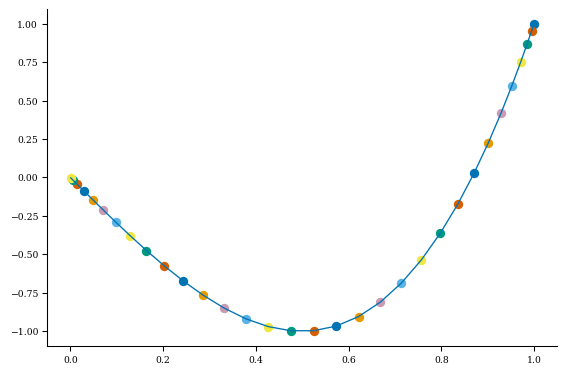

In [5]:
a = jax.scipy.fft.dct(y, type=2 - lobatto)
out = jax.scipy.fft.idct(a, type=2 - lobatto)
plt.plot(x, out)
a = a.at[0].divide(2)
a = a / (N)

for x0 in x:
    x0p = 2 * x0 - 1
    # this part depends on the normalization chosen
    n = jnp.arange(N)
    Tn = jnp.cos(n * jnp.arccos(x0p))
    y0 = jnp.dot(a, Tn)
    plt.scatter(x0, y0)

# 2D Fourier-Chebyshev

In [8]:
def f2_jnp(x, y):
    """2D non-periodic function."""
    return (x**2 + x) * jnp.sin(3 * x) * jnp.cos(y)


def eval_fourier_chebyshev(cf, x0, y0):
    """
    Evaluate Fourier–Chebyshev series at (x0, y0).
    cf[n, m] = Chebyshev–Fourier coefficients.
    """
    M, N = cf.shape

    x0p = 2 * x0 - 1
    n = jnp.arange(N)
    Tn = jnp.cos(n * jnp.arccos(x0p))
    # frequencies are in weird order, have to use fftfreq
    m = jnp.fft.fftfreq(M) * M
    eimy = jnp.exp(1j * m * y0)
    f_x = eimy @ (cf @ Tn)

    return jnp.real(f_x)


N = 16
M = 2 * N
lobatto = False
k = np.arange(N)
if lobatto:
    x = jnp.cos(jnp.pi * k / (N - 1))
else:
    x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * N))

x = (x + 1) / 2
y = np.linspace(0, 2 * np.pi, M, endpoint=False)
X, Y = np.meshgrid(x, y)
z = f2_jnp(X, Y)

# DCT returns the unnormalized coeffs
# the constant term (mode 0) needs special care
# a0 = a0_dct / 2
# an = an_dct / N
zm = jax.scipy.fft.dct(z, axis=1, norm=None)
zm = zm.at[:, 0].divide(2)
zm /= N
# FFT coeffs are also unnormalized, need to divide by M
zmn = jnp.fft.fft(zm, axis=0, norm=None)
zmn /= M

x0 = 0.5
y0 = 1.0
f2_jnp(x0, y0), eval_fourier_chebyshev(zmn, x0, y0)

(Array(0.4042, dtype=float64, weak_type=True), Array(0.4042, dtype=float64))

# 2D Fourier-Chebyshev with rfft() 

In [26]:
def f2_jnp(x, y):
    """2D non-periodic function."""
    return (x**2 + x) * jnp.sin(3 * x) * jnp.sin(y)


def eval_fourier_chebyshev_rfft_direct(cf_rfft, x0, y0, M):
    M_rfft, N = cf_rfft.shape

    x0p = 2 * x0 - 1
    n = jnp.arange(N)
    Tn = jnp.cos(n * jnp.arccos(x0p))
    Rm = cf_rfft @ Tn 
    m = jnp.fft.rfftfreq(M) * M

    # Complex exponentials for positive frequencies
    eimy_pos = jnp.exp(1j * m * y0)
    terms = Rm * eimy_pos
    f_x = jnp.sum(terms[1:-1])
    f_x += jnp.sum(jnp.conjugate(terms[1:-1]))
    f_x += terms[0] + terms[-1]

    return jnp.real(f_x)


N = 32
M = 2 * N
lobatto = False
k = np.arange(N)
if lobatto:
    x = jnp.cos(jnp.pi * k / (N - 1))
else:
    x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * N))

x = (x + 1) / 2
y = np.linspace(0, 2 * np.pi, M, endpoint=False)
X, Y = np.meshgrid(x, y)
z = f2_jnp(X, Y)

# DCT returns the unnormalized coeffs
# the constant term (mode 0) needs special care
# a0 = a0_dct / 2
# an = an_dct / N
zm = jax.scipy.fft.dct(z, axis=1, norm=None)
zm = zm.at[:, 0].divide(2)
zm /= N
# FFT coeffs are also unnormalized, need to divide by M
zmn = jnp.fft.rfft(zm, axis=0, norm=None)
zmn /= M

x0 = 0.5
y0 = 1.0
f2_jnp(x0, y0), eval_fourier_chebyshev_rfft_direct(zmn, x0, y0, M)

(Array(0.6295, dtype=float64, weak_type=True), Array(0.6295, dtype=float64))

# 3D Interpolation with Fourier-Chebyshev

Double Fourier in toroidal and poloidal direction, Chebyshev in radial direction.

In [448]:
eq = get("precise_QA")
L = 16
M, N = 16, 16
k = np.arange(L)
x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * L))

rho = (x + 1) / 2
grid = LinearGrid(rho=rho, M=8, N=8, sym=False, NFP=1)
data = eq.compute("R", grid=grid)
R = data["R"]
# jnp.column_stack([grid.nodes, R])

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [449]:
Rf = R.reshape(grid.num_zeta, grid.num_rho, grid.num_theta)

In [450]:
rs = grid.nodes[:, 0].reshape(grid.num_zeta, grid.num_rho, grid.num_theta)[0, :, :]
ts = grid.nodes[:, 1].reshape(grid.num_zeta, grid.num_rho, grid.num_theta)[0, :, :]
x = rs * jnp.cos(ts)
y = rs * jnp.sin(ts)
plot_2d_surface(x, y, Rf[0, :, :]*10)

In [451]:
def eval_fourier_chebyshev_3d(cf, r0, t0, z0):
    N, L, M = cf.shape

    r0p = 1 - 2 * r0
    l = jnp.arange(L)
    Tl = jnp.cos(l * jnp.arccos(r0p))
    f_l = jnp.einsum("nlm,l->nm", cf, Tl)
    # frequencies are in weird order, have to use fftfreq
    m = jnp.fft.fftfreq(M) * M
    expm = jnp.exp(1j * m * t0) / M
    f_lm = jnp.einsum("nm,m->n", f_l, expm)
    n = jnp.fft.fftfreq(N) * N
    expn = jnp.exp(1j * n * z0) / N
    f_lmn = jnp.einsum("n,n->", f_lm, expn)

    return jnp.real(f_lmn)


zl = jax.scipy.fft.dct(Rf, axis=1, norm=None)
zl = zl.at[:, 0, :].divide(2)
zl /= L
# FFT coeffs are also unnormalized, need to divide by M
zlm = jnp.fft.fft(zl, axis=2, norm=None)
zlmn = jnp.fft.fft(zlm, axis=0, norm=None)

In [452]:
i, j = 10, 3
eval_fourier_chebyshev_3d(zlmn, r0=rs[i, j], t0=ts[i, j], z0=0), Rf[0, i, j]

(Array(1.2283, dtype=float64), Array(1.2283, dtype=float64))